In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

from yellowbrick.features import Rank1D

from tqdm import tqdm

from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.combine import SMOTETomek

In [3]:
df = pd.read_csv('/content/drive/MyDrive/data_extracted.csv')

In [4]:
bins = [0, 10,15,20,25, 30, 40, 50, 60, 70, 80, 90, 100,120,400]
df['price'] = pd.cut(df['price'], bins, labels=False)

In [5]:
#chuyen du lieu category ve numeric
columns = ['polistic', 'furniture', 'district', 'house_direct', 'balcony_direct']
for column in columns:
    le = preprocessing.LabelEncoder()
    df[column] = le.fit_transform(df[column])

/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


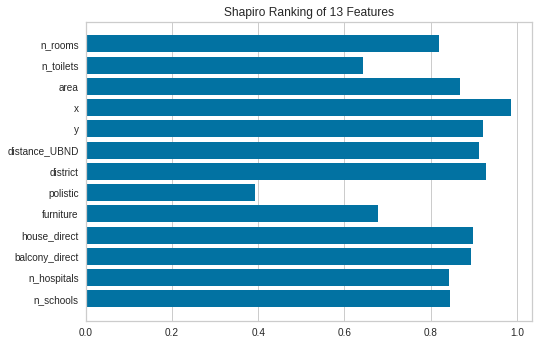

In [ ]:
visualizer = Rank1D(algorithm='shapiro')
X = df[df.columns[0:13]]
y = df[df.columns[-1:]]
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

In [9]:
from sklearn.utils import resample

# Get the unique class labels
class_labels = df.price.unique()

# Create a list to store the oversampled dataframes
data_oversampled = []

# Loop over each class label
for label in class_labels:
    # Separate majority and minority classes
    data_majority = df[df.price!=label]
    data_minority = df[df.price==label]
 
    # Upsample minority class
    data_minority_upsampled = resample(data_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(data_majority),    # to match majority class
                                     random_state=123) # reproducible results
 
    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])
    
    # Add the oversampled dataframe to the list
    data_oversampled.append(data_upsampled)

# Concatenate all the oversampled dataframes
data_oversampled = pd.concat(data_oversampled)

In [10]:
data = data_oversampled.values
#data = df.values
X, y = data[:,:-1], data[:,-1]

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [11]:
rf = RandomForestClassifier(criterion='entropy', n_estimators=150)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=150)

In [12]:
print("train acc:" + str(rf.score(X_train, y_train)))
print("test acc:" + str(rf.score(X_test, y_test)))
print("f1 score:" + str(f1_score(y_test, rf.predict(X_test), average="macro")))
print("recall score:" + str(recall_score(y_test, rf.predict(X_test), average="macro")))
print("precision score:" + str(precision_score(y_test, rf.predict(X_test), average="macro")))

train acc:0.9719158231169654
test acc:0.9704981277658005
f1 score:0.9728324051941983
recall score:0.9742950177688212
precision score:0.9714925776026198


## model selection

In [ ]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_valid, y_valid, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

100%|██████████| 3/3 [00:31<00:00, 10.52s/it]


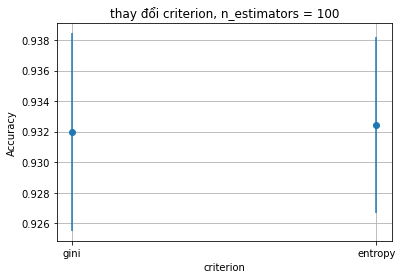

In [ ]:
title = "thay đổi criterion, n_estimators = 100"
xlabel = "criterion"
X = []
Y = []
error = []

for criterion in tqdm(["gini", "entropy"]):
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=100)
    mean, std = cross_validation(text_clf)
    X.append(str(criterion))
    Y.append(mean)
    error.append(std)

plot(title, xlabel, X, Y, error)
plt.show()

100%|██████████| 3/3 [00:52<00:00, 17.49s/it]


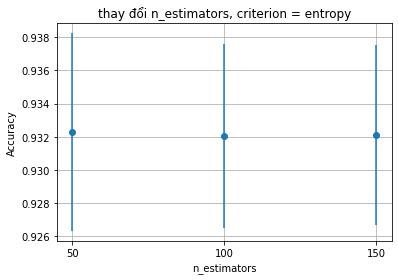

In [ ]:
title = "thay đổi n_estimators, criterion = entropy"
xlabel = "n_estimators"
X = []
Y = []
error = []

for i in tqdm([50,100,150]):
    text_clf = RandomForestClassifier(criterion='entropy', n_estimators=i)
    mean, std = cross_validation(text_clf)
    X.append(str(i))
    Y.append(mean)
    error.append(std)
plot(title, xlabel, X, Y, error)
plt.show()